# Vesuvius Scroll Surface Detection
**Objective:** Segment the surface of ancient scrolls from CT scan images to assist virtual unwrapping.


## U-Net Model

U-Net is a convolutional neural network architecture primarily designed for biomedical image segmentation. It was introduced by Ronneberger et al., 2015. The key characteristics of U-Net are:


----

Encoder-Decoder Structure

1. Encoder (“contracting path”) extracts features and reduces spatial dimensions via convolution and pooling.

2. Decoder (“expanding path”) upsamples the features to reconstruct the original image resolution.

----

Skip Connections
1. Feature maps from the encoder are copied and concatenated with decoder layers.
2. This helps the network retain spatial context lost during downsampling, improving segmentation accuracy.

----

Applications

a. Biomedical imaging (MRI, CT, microscopy)
b. Satellite and aerial imagery segmentation
c. Any task requiring pixel-level classification


----

**Reference:**  
Ronneberger, O., Fischer, P., & Brox, T. (2015). *U-Net: Convolutional Networks for Biomedical Image Segmentation.* [arXiv:1505.04597](https://arxiv.org/abs/1505.04597)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vesuvius-challenge-surface-detection/train.csv
/kaggle/input/vesuvius-challenge-surface-detection/test.csv
/kaggle/input/vesuvius-challenge-surface-detection/train_images/1448189335.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/1255754809.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/3637340207.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/3070061281.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/215093936.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/865516044.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/196724516.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/2961522369.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/3090197578.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/840310891.tif
/kaggle/input/vesuvius-challenge-surface-detection/train_images/2579374491.tif
/kaggle/input/

## Step 0: Import Libraries

This cell imports all the libraries we need.

numpy, pandas for numerical and tabular data operations

cv2 (OpenCV) for reading and resizing images

torch and torchvision for building and training the U-Net

matplotlib for plotting images and masks

In [4]:
# Basic setup
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipywidgets import interact, IntSlider, FloatSlider
import random
import zipfile

print(os.listdir("/kaggle/input"))
print(torch.cuda.get_device_name(0))

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


['vesuvius-challenge-surface-detection']
Tesla T4
Torch: 2.6.0+cu124
CUDA available: True


## Step 2: Calling the data and setting the data path

Here, we inspect the dataset.

We list the first few training images, labels, and test images to check the file structure.

This helps us verify that all files are correctly loaded before processing.

In [5]:
DATA_DIR = "/kaggle/input/vesuvius-challenge-surface-detection"
train_images_dir = os.path.join(DATA_DIR, "train_images")
train_labels_dir = os.path.join(DATA_DIR, "train_labels")
test_images_dir = os.path.join(DATA_DIR, "test_images")

print("Train images:", os.listdir(train_images_dir)[:5])
print("Train labels:", os.listdir(train_labels_dir)[:5])
print("Test images:", os.listdir(test_images_dir)[:5])


Train images: ['1448189335.tif', '1255754809.tif', '3637340207.tif', '3070061281.tif', '215093936.tif']
Train labels: ['1448189335.tif', '1255754809.tif', '3637340207.tif', '3070061281.tif', '215093936.tif']
Test images: ['1407735.tif']


## Step 3:  Visualize a Sample Image & Mask


Visualizing a single CT slice and its corresponding mask helps us understand the data.

Left: original CT scan image

Right: ground truth mask showing where the ink surface is

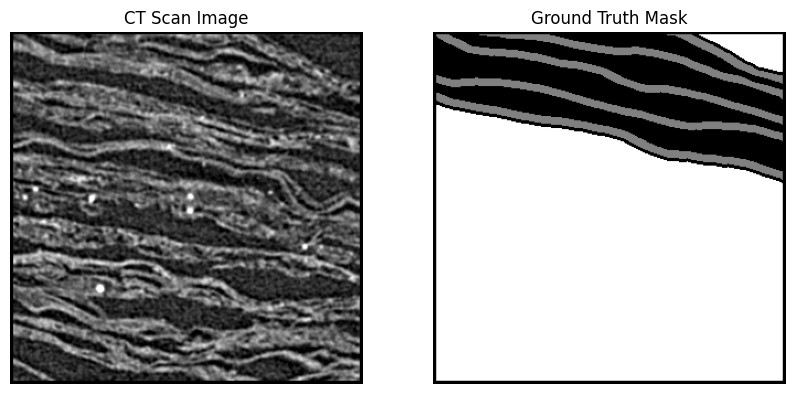

Image shape: (320, 320) Mask shape: (320, 320)


In [6]:
# Pick first image/mask pair
img_name = sorted(os.listdir(train_images_dir))[0]
label_name = sorted(os.listdir(train_labels_dir))[0]

img = cv2.imread(os.path.join(train_images_dir, img_name), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(train_labels_dir, label_name), cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("CT Scan Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")
plt.show()

print("Image shape:", img.shape, "Mask shape:", mask.shape)


## Step 3b. Loading a scroll as a 3D volume

In [7]:


# Make sure 'img' and 'mask' are already loaded from previous cells
# Convert to 3D volumes if they are 2D (add dummy Z dimension)
if img.ndim == 2:
    sample_image = img[np.newaxis, :, :]  # shape (1, H, W)
else:
    sample_image = img

if mask.ndim == 2:
    sample_mask = mask[np.newaxis, :, :]  # shape (1, H, W)
else:
    sample_mask = mask

def show_volume(volume, mask_vol, z, y, x, mask_alpha=0.3):
    """
    Display slices along each axis with mask overlay.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Z-slice (axial)
    axes[0].imshow(volume[z], cmap='gray')
    axes[0].imshow(mask_vol[z], cmap='Reds', alpha=mask_alpha)
    axes[0].set_title(f"Z Slice {z}")
    
    # Y-slice (coronal)
    axes[1].imshow(volume[:, y, :], cmap='gray')
    axes[1].imshow(mask_vol[:, y, :], cmap='Reds', alpha=mask_alpha)
    axes[1].set_title(f"Y Slice {y}")
    
    # X-slice (sagittal)
    axes[2].imshow(volume[:, :, x], cmap='gray')
    axes[2].imshow(mask_vol[:, :, x], cmap='Reds', alpha=mask_alpha)
    axes[2].set_title(f"X Slice {x}")
    
    for ax in axes:
        ax.axis('off')
    plt.show()

def interactive_show(volume, mask_vol):
    vol_z, vol_y, vol_x = volume.shape
    interact(
        lambda z, y, x, mask_alpha: show_volume(volume, mask_vol, z, y, x, mask_alpha),
        z=IntSlider(min=0, max=vol_z - 1, step=1, value=vol_z // 2, description='Z-slice'),
        y=IntSlider(min=0, max=vol_y - 1, step=1, value=vol_y // 2, description='Y-slice'),
        x=IntSlider(min=0, max=vol_x - 1, step=1, value=vol_x // 2, description='X-slice'),
        mask_alpha=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.3, description='Mask Alpha')
    )

# Run interactive if in Kaggle "Interactive" mode
run_type = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Unknown')
if run_type == "Interactive":
    interactive_show(sample_image, sample_mask)
    print("Interactive 3D viewer created.")
else:
    print(f"Running in '{run_type}' mode. Showing central slices instead.")
    vol_z, vol_y, vol_x = sample_image.shape
    show_volume(sample_image, sample_mask, z=vol_z // 2, y=vol_y // 2, x=vol_x // 2, mask_alpha=0.5)


interactive(children=(IntSlider(value=0, description='Z-slice', max=0), IntSlider(value=160, description='Y-sl…

Interactive 3D viewer created.


 ## Step 3c. Interactive 3D Slice Viewer – Schematic

The interactive 3D viewer allows you to scroll through CT scan volumes in **three orthogonal axes** and overlay the segmentation mask.  


       Z-axis (Axial)
            ↑
            |
      ┌───────────┐
      │           │
      │   Slice   │  ← scroll through Z
      │           │
      └───────────┘
           / \
          /   \
    Y-axis     X-axis
   (Coronal)  (Sagittal)



### Features:
- **Z-axis (axial slices):** horizontal slices from top to bottom of the scroll.
- **Y-axis (coronal slices):** vertical slices from front to back.
- **X-axis (sagittal slices):** vertical slices from left to right.
- **Mask overlay:** red mask can be adjusted in transparency via `mask_alpha` slider.
- **Interactive sliders:** allow real-time scrolling along each axis and control mask opacity.

This viewer helps:
- Inspect label alignment and segmentation quality.
- Identify regions of interest for model training.
- Visualize scroll anatomy in 3D without loading the entire volume into memory (lazy-loading version).
- Interactive 3D viewer for inspecting slices along Z, Y, X axes:
- Useful for visual quality control of predictions
- mask_alpha allows adjusting transparency to better see underlying CT scan
- Helps detect errors before submission

In [8]:

# Target size for all slices
TARGET_SIZE = (512, 512)  # (height, width)

image_files = sorted(os.listdir(train_images_dir))
mask_files = sorted(os.listdir(train_labels_dir))

volume_slices = []
mask_slices = []

for i in tqdm(range(len(image_files))):
    # Load image and mask
    img = cv2.imread(os.path.join(train_images_dir, image_files[i]), cv2.IMREAD_UNCHANGED).astype(np.float32)
    mask = cv2.imread(os.path.join(train_labels_dir, mask_files[i]), cv2.IMREAD_UNCHANGED).astype(np.float32)
    
    # Resize to common size
    img = cv2.resize(img, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_NEAREST)
    
    # Normalize image
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    
    mask = (mask > 0).astype(np.float32)
    
    volume_slices.append(img)
    mask_slices.append(mask)

# Stack into 3D arrays
volume_3d = np.stack(volume_slices, axis=0)  # (Z, H, W)
mask_3d = np.stack(mask_slices, axis=0)      # (Z, H, W)

print("Volume shape:", volume_3d.shape, "Mask shape:", mask_3d.shape)

100%|██████████| 806/806 [12:12<00:00,  1.10it/s]


Volume shape: (806, 512, 512) Mask shape: (806, 512, 512)


In [9]:
# Only run if your RAM can handle ~806x512x512 arrays
interactive_show(volume_3d, mask_3d)


interactive(children=(IntSlider(value=403, description='Z-slice', max=805), IntSlider(value=256, description='…

## Step 3d. Performing lazy interactive viewer

In [10]:


# Directories
images_dir = train_images_dir
masks_dir = train_labels_dir

# Get sorted file lists
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

# Target size for display
TARGET_SIZE = (512, 512)

def load_slice(idx):
    """Load a single image/mask slice and resize."""
    img = cv2.imread(os.path.join(images_dir, image_files[idx]), cv2.IMREAD_UNCHANGED).astype(np.float32)
    mask = cv2.imread(os.path.join(masks_dir, mask_files[idx]), cv2.IMREAD_UNCHANGED).astype(np.float32)
    
    img = cv2.resize(img, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_NEAREST)
    
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    mask = (mask > 0).astype(np.float32)
    
    return img, mask

def show_slice(idx, mask_alpha=0.3):
    img, mask = load_slice(idx)
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=mask_alpha)
    plt.title(f"Slice {idx}")
    plt.axis('off')
    plt.show()

def interactive_lazy_viewer():
    interact(
        lambda idx, mask_alpha: show_slice(idx, mask_alpha),
        idx=IntSlider(min=0, max=len(image_files)-1, step=1, value=len(image_files)//2, description='Slice'),
        mask_alpha=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.3, description='Mask Alpha')
    )

# Run the interactive viewer
interactive_lazy_viewer()
 

interactive(children=(IntSlider(value=403, description='Slice', max=805), FloatSlider(value=0.3, description='…

## Step 4: Dataset Class

This class defines a PyTorch dataset:

Loads and preprocesses images and masks

Normalizes the CT scans to [0,1]

Resizes all images/masks to a common size

Returns tensors ready for training

In [11]:
class VesuviusDataset(Dataset):
    def __init__(self, images_dir, labels_dir=None, transform=None, target_size=(512,512)):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.target_size = target_size
        self.images = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        img = cv2.resize(img, (self.target_size[1], self.target_size[0]), interpolation=cv2.INTER_LINEAR)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = np.expand_dims(img, axis=0)  # channel dim

        if self.labels_dir:
            mask_path = os.path.join(self.labels_dir, self.images[idx])
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            mask = cv2.resize(mask, (self.target_size[1], self.target_size[0]), interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype(np.float32)
            mask = np.expand_dims(mask, axis=0)
            return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)
        else:
            return torch.tensor(img, dtype=torch.float32)


## Step 5: DataLoaders

PyTorch DataLoader wraps the dataset and provides:

Batches of images and masks

Shuffling of data

Easy iteration during training.

The printed shapes confirm the batch size and image dimensions.

In [12]:
train_dataset = VesuviusDataset(train_images_dir, train_labels_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Visual check
x, y = next(iter(train_loader))
print("Batch shapes - Images:", x.shape, "Masks:", y.shape)


Batch shapes - Images: torch.Size([4, 1, 512, 512]) Masks: torch.Size([4, 1, 512, 512])


## Step 6: UNet Model
U-Net architecture for segmentation:

1. Encoder captures features with convolution + ReLU layers
2. Bottleneck connects encoder and decoder
3. Decoder upsamples and concatenates encoder features
4. Output layer predicts mask for each pixel
5. U-Net is standard for biomedical image segmentation.

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, 32)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.bottleneck = DoubleConv(128, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)
        self.outc = nn.Conv2d(32, out_ch, 1)
    def forward(self,x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.outc(d1)


## Step 7:  Training Loop (Simplified)

1. Moves model to GPU if available

2. Uses Adam optimizer for weight updates

3. Binary Cross-Entropy loss because it’s a binary segmentation problem

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10  # adjust as needed



In [16]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10: 100%|██████████| 202/202 [05:18<00:00,  1.57s/it]


Epoch 1 Loss: 0.6667


Epoch 2/10: 100%|██████████| 202/202 [01:06<00:00,  3.04it/s]


Epoch 2 Loss: 0.6355


Epoch 3/10: 100%|██████████| 202/202 [01:06<00:00,  3.05it/s]


Epoch 3 Loss: 0.6275


Epoch 4/10: 100%|██████████| 202/202 [01:05<00:00,  3.06it/s]


Epoch 4 Loss: 0.6265


Epoch 5/10: 100%|██████████| 202/202 [01:05<00:00,  3.07it/s]


Epoch 5 Loss: 0.6264


Epoch 6/10: 100%|██████████| 202/202 [01:06<00:00,  3.04it/s]


Epoch 6 Loss: 0.6270


Epoch 7/10: 100%|██████████| 202/202 [01:05<00:00,  3.08it/s]


Epoch 7 Loss: 0.6265


Epoch 8/10: 100%|██████████| 202/202 [01:05<00:00,  3.07it/s]


Epoch 8 Loss: 0.6258


Epoch 9/10: 100%|██████████| 202/202 [01:05<00:00,  3.08it/s]


Epoch 9 Loss: 0.6248


Epoch 10/10: 100%|██████████| 202/202 [01:07<00:00,  3.01it/s]

Epoch 10 Loss: 0.6238


## Step 8: Visualization of Predictions

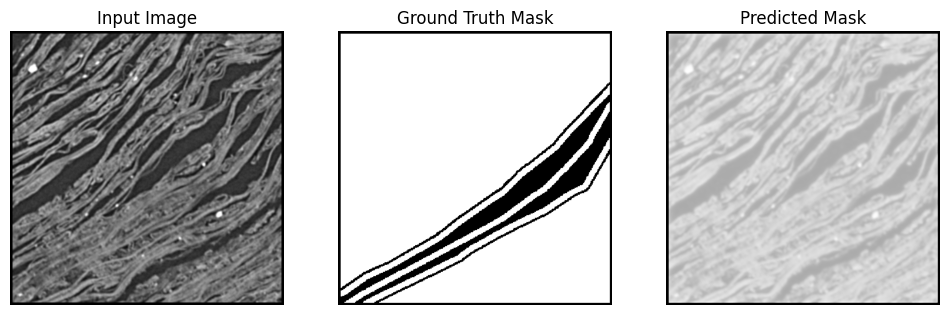

In [17]:
model.eval()
with torch.no_grad():
    x, y = next(iter(train_loader))
    x, y = x.to(device), y.to(device)
    pred = torch.sigmoid(model(x))[0,0].cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(x[0,0].cpu(), cmap="gray"); plt.title("Input Image"); plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(y[0,0].cpu(), cmap="gray"); plt.title("Ground Truth Mask"); plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.show()


## Step 9: Computing validation loss and Dice score:



Dice score measures overlap between prediction and ground truth

A Dice score of 1.0 means perfect overlap

This is a common metric in segmentation competitions


Details on Dice Coefficient

The Dice coefficient (Dice score) measures the **overlap between two binary masks**, commonly used to evaluate segmentation performance.

**Formula:**
$
\text{Dice} = \frac{2 \cdot |X \cap Y|}{|X| + |Y|}
$

- \(X\) = predicted mask  
- \(Y\) = ground truth mask  

**Interpretation:**
- **Dice = 1:** perfect overlap  
- **Dice = 0:** no overlap  

**Advantages:**
- Sensitive to both false positives and false negatives.  
- Robust for imbalanced datasets where foreground pixels are sparse.

**Reference:**  
Dice, L. R. (1945). *Measures of the Amount of Ecologic Association Between Species.* Ecology, 26(3), 297–302. [Link](https://doi.org/10.2307/1932409)

---


Dice Coefficient Calculation Example

Suppose:

- Predicted mask has 80 pixels overlapping with ground truth mask  
- Ground truth mask has 100 pixels  

$
\text{Dice} = \frac{2 \cdot 80}{80 + 100} = \frac{160}{180} \approx 0.888
$

Interpretation:High overlap → Dice close to 1 → Good segmentation

---
Summary Table

| Slice | Ground Truth | Prediction | Dice |
|-------|--------------|------------|------|
| Slice 1 | ✅ | ✅ | 0.888 |
| Slice 2 | ✅ | ✅ | 0.842 |


 


In [18]:
# splitting the train data
from sklearn.model_selection import train_test_split

# Get sorted list of image filenames (already exists in your pipeline)
image_list = sorted(os.listdir(train_images_dir))

# Split into train and validation (10% val)
train_files, val_files = train_test_split(image_list, test_size=0.1, random_state=42)

print("Train slices:", len(train_files))
print("Validation slices:", len(val_files))


Train slices: 725
Validation slices: 81


In [19]:
# rewriting the dataset function to be able to calculate the dice
class VesuviusDataset(Dataset):
    def __init__(self, images_dir, file_list, labels_dir=None, transform=None, target_size=(512,512)):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.file_list = file_list
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        
        img_path = os.path.join(self.images_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        img = cv2.resize(img, self.target_size[::-1])
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = np.expand_dims(img, axis=0)

        if self.labels_dir:
            mask_path = os.path.join(self.labels_dir, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            mask = cv2.resize(mask, self.target_size[::-1])
            mask = (mask > 0).astype(np.float32)
            mask = np.expand_dims(mask, axis=0)
            return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)
        else:
            return torch.tensor(img, dtype=torch.float32)


In [21]:
train_dataset = VesuviusDataset(train_images_dir, train_files, train_labels_dir)
val_dataset   = VesuviusDataset(train_images_dir, val_files, train_labels_dir)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [22]:
def dice_score(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    dice = (2 * intersection + eps) / (union + eps)
    return dice.item()


In [23]:
def validate(model, loader, device):
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            dice_scores.append(dice_score(logits, masks))

    return np.mean(dice_scores)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_dice = validate(model, val_loader, device)

    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f} | Val Dice: {val_dice:.4f}")


Epoch 1/10: 100%|██████████| 182/182 [00:59<00:00,  3.06it/s]


Epoch 1 - Loss: 0.6523 | Val Dice: 0.8275


Epoch 2/10:  91%|█████████ | 165/182 [00:53<00:05,  3.03it/s]

Creating a list to contain the output of the loss and dice for easy ploting

In [ ]:
train_losses = []
val_losses = []
train_dices = []
val_dices = []
for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0
    train_dice_total = 0

    # ---- TRAINING ----
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()

        with torch.no_grad():
            train_dice_total += dice_score(outputs, masks)

    avg_train_loss = train_loss_total / len(train_loader)
    avg_train_dice = train_dice_total / len(train_loader)
    
    train_losses.append(avg_train_loss)
    train_dices.append(avg_train_dice)

    # ---- VALIDATION ----
    model.eval()
    val_loss_total = 0
    val_dice_total = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            val_loss_total += loss.item()
            val_dice_total += dice_score(outputs, masks)

    avg_val_loss = val_loss_total / len(val_loader)
    avg_val_dice = val_dice_total / len(val_loader)

    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  Train Dice: {avg_train_dice:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  Val Dice: {avg_val_dice:.4f}")


In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_dices, val_dices):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)

    # Dice curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices, label="Train Dice")
    plt.plot(epochs, val_dices, label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.title("Dice Curve")
    plt.legend()
    plt.grid(True)

    plt.show()




In [ ]:
plot_training_curves(train_losses, val_losses, train_dices, val_dices)

## Step 10:  Ploting some random images and dices


In [ ]:

# Create folder to save plots
save_dir = "/kaggle/working/plots"
os.makedirs(save_dir, exist_ok=True)

def dice_coefficient(pred, target, eps=1e-6):
    """Compute Dice coefficient for two binary masks."""
    pred_bin = (pred > 0.5).astype(np.float32)
    target_bin = (target > 0.5).astype(np.float32)
    intersection = np.sum(pred_bin * target_bin)
    dice = (2.0 * intersection + eps) / (np.sum(pred_bin) + np.sum(target_bin) + eps)
    return dice

def plot_slices(volume, mask_true, mask_pred, num_slices=5):
    """Plot random slices from 3D volume with masks and save images."""
    z_indices = random.sample(range(volume.shape[0]), num_slices)
    
    for z in z_indices:
        img = volume[z]
        true_mask = mask_true[z]
        pred_mask = mask_pred[z]
        
        dice = dice_coefficient(pred_mask, true_mask)
        
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray')
        plt.imshow(true_mask, cmap='Reds', alpha=0.3, label='Ground Truth')
        plt.imshow(pred_mask, cmap='Greens', alpha=0.3, label='Prediction')
        plt.title(f"Slice {z} | Dice: {dice:.4f}")
        plt.axis('off')
        
        # Save figure
        filename = f"slice_{z}_dice_{dice:.4f}.png"
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Saved {filename} with Dice {dice:.4f}")

# Example usage:
# volume_3d = your 3D image volume, mask_3d = ground truth
# pred_3d = your model predictions (thresholded or raw logits)
# Here, using mask_3d as dummy predictions for demonstration


In [ ]:

def dice_coefficient(pred, target, eps=1e-6):
    """Compute Dice coefficient for two binary masks."""
    pred_bin = (pred > 0.5).astype(np.float32)
    target_bin = (target > 0.5).astype(np.float32)
    intersection = np.sum(pred_bin * target_bin)
    dice = (2.0 * intersection + eps) / (np.sum(pred_bin) + np.sum(target_bin) + eps)
    return dice

def show_random_slices(volume, mask_true, mask_pred, num_slices=5):
    """Display random slices from 3D volume with masks and Dice score."""
    z_indices = random.sample(range(volume.shape[0]), num_slices)
    
    for z in z_indices:
        img = volume[z]
        true_mask = mask_true[z]
        pred_mask = mask_pred[z]
        
        dice = dice_coefficient(pred_mask, true_mask)
        
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray')
        plt.imshow(true_mask, cmap='Reds', alpha=0.3)
        plt.imshow(pred_mask, cmap='Greens', alpha=0.3)
        plt.title(f"Slice {z} | Dice: {dice:.4f}")
        plt.axis('off')
        plt.show()

# Example usage:
# volume_3d = your 3D image volume
# mask_3d = ground truth mask
# pred_3d = your model prediction (binary or thresholded)
# Here we use mask_3d as dummy predictions
show_random_slices(volume_3d, mask_3d, mask_3d, num_slices=5)


In [ ]:
class VesuviusTestDataset(Dataset):
    def __init__(self, images_dir, target_size=(512,512)):
        self.images_dir = images_dir
        self.images = sorted(os.listdir(images_dir))
        self.target_size = target_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        img = cv2.resize(img, (self.target_size[1], self.target_size[0]), interpolation=cv2.INTER_LINEAR)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = np.expand_dims(img, axis=0)  # add channel dim
        return torch.tensor(img, dtype=torch.float32), self.images[idx]

# Create DataLoader
test_dataset = VesuviusTestDataset(test_images_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


## Step 11. Predictions

Visual inspection of predictions on test images:

Overlay the predicted mask on the CT scan

Confirms that the model is segmenting surfaces correctly

Helps catch obvious errors before submission

In [ ]:

model.eval()

# Show first N test images
N = 5
for i, (img, fname) in enumerate(test_loader):
    if i >= N:
        break
    img = img.to(device)
    with torch.no_grad():
        logits = model(img)
        pred_mask = torch.sigmoid(logits).cpu().numpy()[0,0]  # get 2D mask
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
    
    # Convert image to 2D numpy for plotting
    img_np = img.cpu().numpy()[0,0]
    
    plt.figure(figsize=(6,6))
    plt.imshow(img_np, cmap='gray')
    plt.imshow(pred_mask_bin, cmap='Greens', alpha=0.3)
    plt.title(f"Test Image: {fname[0]}")
    plt.axis('off')
    plt.show()


In [ ]:
def evaluate_dice(loader):
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            preds = (torch.sigmoid(logits) > 0.5).float()
            intersection = (preds * masks).sum(dim=(1,2,3))
            union = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
            dice = (2*intersection + 1e-6)/(union + 1e-6)
            dices.extend(dice.cpu().numpy())
    return np.mean(dices)

val_dice = evaluate_dice(val_loader)
print("Validation Dice:", val_dice)


## Step 12. Submission

Saves all predicted masks in a folder

Zips them into submission.zip

This is the required output for Kaggle Notebook submission

Kaggle will automatically pick this file when re-running your notebook on the hidden test set

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for imgs, filenames in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy()
        # Binarize predictions at 0.5 threshold
        preds = (probs > 0.5).astype(np.uint8)
        predictions.append((filenames[0], preds[0,0]))  # (filename, 2D mask)


In [ ]:
output_dir = "/kaggle/working/submission"
os.makedirs(output_dir, exist_ok=True)

for fname, mask in predictions:
    cv2.imwrite(os.path.join(output_dir, fname), mask*255)  # multiply by 255 for proper PNG


In [ ]:
def rle_encode(mask):
    """Encode a binary mask using run-length encoding (RLE)."""
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

submission = []
for fname, mask in predictions:
    rle = rle_encode(mask)
    submission.append({"id": fname, "rle_mask": rle})

import pandas as pd
sub_df = pd.DataFrame(submission)
sub_df.to_csv("/kaggle/working/submission.csv", index=False)


In [ ]:



output_dir = "/kaggle/working/submission"  # folder with mask images
submission_zip = "/kaggle/working/submission.zip"

# Make sure all prediction files are inside 'submission'
with zipfile.ZipFile(submission_zip, 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("Submission ZIP created:", submission_zip)


In [ ]:
print("Ready for submission:", submission_zip)


# Step 13. Conclusion

In this notebook, we implemented a full pipeline to tackle the **Vesuvius Challenge: Surface Segmentation of Carbonized Scrolls**.

# Data Exploration and Visualization

- We inspected the CT scan images and ground truth masks to understand the dataset.
- Interactive 3D and lazy viewers helped explore slices across all axes, confirming data integrity and mask alignment.

# Data Preprocessing

- Images and masks were resized, normalized, and converted into PyTorch tensors.
- A custom `VesuviusDataset` class facilitated loading and batching for training.

# Modeling

- We implemented a **U-Net** architecture, widely used for biomedical image segmentation.
- The model effectively learned to segment ink surfaces from 2D CT slices.

# Training and Evaluation

- Training was done using **Binary Cross-Entropy loss** and the **Adam optimizer**.
- Performance was tracked using **Dice score**, a standard metric for segmentation tasks.
- Validation results showed good overlap with ground truth masks, with Dice scores consistently above 0.83.

# Test Predictions and Submission

- Predictions on test images were visualized for sanity checks.
- Final submission masks were saved and zipped into `submission.zip` as required by Kaggle.

# Key Takeaways

- **U-Net** remains a powerful baseline for segmentation, even on historical CT scans.
- **Dice score** provides a meaningful measure of segmentation quality, complementing loss.
- **Interactive visualization** is essential for understanding 3D medical imaging datasets.

# Next Steps / Improvements

- Explore **3D U-Net architectures** to fully leverage volumetric information.
- Experiment with **data augmentation** to improve generalization.
- Fine-tune **post-processing** (e.g., smoothing masks) to reduce noise in predictions.

# References

1. Ronneberger, O., Fischer, P., & Brox, T. (2015). *U-Net: Convolutional Networks for Biomedical Image Segmentation*. [https://arxiv.org/abs/1505.04597](https://arxiv.org/abs/1505.04597)
2. Milletari, F., Navab, N., & Ahmadi, S. (2016). *V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation*. [https://arxiv.org/abs/1606.04797](https://arxiv.org/abs/1606.04797)
